In [1]:
import os
from os import path
import pandas as pd
import time
import keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import layers
import sklearn.model_selection as sk
from IPython import display
import matplotlib.pyplot as plt
import numpy as np

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
physical_devices = tf.config.list_physical_devices('GPU') 
for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)

In [4]:
def getNormed(this_array, this_min = 0, this_max = 255, set_to_int = True):
    new_var = this_array.copy()
    rat = (this_max - this_min)/(new_var.max() - new_var.min())
    new_var = new_var * rat
    new_var -= new_var.min()
    new_var += this_min
    if set_to_int:
        return new_var.astype('uint8')
    return new_var

In [5]:
def getNormed1(this_array, set_to_int = True):
    std_dev = np.std(this_array)
    mean = np.mean(this_array)
    normalised_input = (this_array - mean) / std_dev
    if set_to_int:
        return normalised_input.astype('uint8')
    return normalised_input

In [6]:
def getSamePadding(this_array):
    # Array to be added as row
    row_to_be_added = this_array[70]
    # Adding row to numpy array
    result = np.vstack ((this_array, row_to_be_added) )
    
    # Array to be added as column
    column = this_array[:, 70]
    last_item = this_array[70, 70]
    
    # Adding column to numpy array
    column_to_be_added = np.append(column, last_item)
    
    # stack column to numpy array
    new_img = np.column_stack((result, column_to_be_added))
    return new_img

In [7]:
train = pd.read_csv(r'\Users\aalmans8\Documents\VAE\Train.csv')
test = pd.read_csv(r'\Users\aalmans8\Documents\VAE\Test.csv')

In [8]:
len(test)

145

In [9]:
train_ids = train['noduleID']
test_ids = test['noduleID']

In [10]:
train_ids = np.array(train_ids)
test_ids = np.array(test_ids)

In [11]:
# collect all images for training
image_folder = r'\Users\aalmans8\Documents\VAE\images_1332'
train_images = []
test_images = []
noduleID_array = []
print(image_folder)

for dir1 in os.listdir(image_folder):
    print(dir1)
    if not dir1.startswith('.'):
        for file in os.listdir(os.path.join(image_folder, dir1)):
            #print(file)
            noduleID = file.split('.')[0]
            if not file.startswith('.'):
                noduleID = int(noduleID)
                #if noduleID in train_ids:
                noduleID_array.append(noduleID)
                temp_image = np.loadtxt(os.path.join(image_folder, dir1,file))
                temp_image = getNormed(temp_image)
                #temp_image = getNormed1(temp_image)
                enlarged_img = getSamePadding(temp_image)
                train_images.append(enlarged_img)
            
                ''' if noduleID in test_ids:
                    noduleID_array.append(noduleID)
                    temp_image = np.loadtxt(os.path.join(image_folder, dir1,file))
                    temp_image = getNormed(temp_image)
                    enlarged_img = getSamePadding(temp_image)
                    test_images.append(enlarged_img) '''

\Users\aalmans8\Documents\VAE\images_1332
.DS_Store
Malignancy_1
Malignancy_2
Malignancy_3
Malignancy_4
Malignancy_5


In [12]:
len(train_images)

1332

In [13]:
#len(test_images)

In [14]:
train_images = np.array(train_images)
#test_images = np.array(test_images)

In [15]:
x_train, x_test, y_train, y_test = sk.train_test_split(train_images,noduleID_array,test_size=0.2, random_state = 42)

In [16]:
#x_train = train_images.reshape(train_images.shape[0], 72, 72, 1).astype("float32")
#x_test = test_images.reshape(test_images.shape[0], 72, 72, 1).astype("float32")

In [17]:
#len(x_train)

In [18]:
train_dataset = tf.data.Dataset.from_tensor_slices(x_train).\
shuffle(6000).batch(1)# batch 128 gives similar results

In [19]:
#test_dataset = tf.data.Dataset.from_tensor_slices(x_test).batch(1)

In [20]:
#tf.data.experimental.enable_debug_mode()

In [21]:
normalization_layer = layers.experimental.preprocessing.Rescaling(scale=1./127.5, offset=-1)
normalized_ds = train_dataset.map(lambda x: normalization_layer(x))
image_batch = next(iter(normalized_ds))
first_image = image_batch[0]

In [22]:
#t_normalized_ds = test_dataset.map(lambda x: normalization_layer(x))
#t_image_batch = next(iter(t_normalized_ds))

In [23]:
input_encoder = (72, 72, 1)
input_decoder = (70,)

In [24]:
def sampling(input_1,input_2):
    #input1 = layers.Lambda(sampling_model, name='encoder_output')([mean, var])
    mean = keras.Input(shape=input_1, name='input_layer1')
    log_var = keras.Input(shape=input_2, name='input_layer2')
    out = layers.Lambda(sampling_model, name='encoder_output')([mean, log_var])
    enc_2 = tf.keras.Model([mean,log_var], out,  name="Encoder_2")
    # print(enc_2.summary())
    return enc_2

In [25]:
def sampling_model(distribution_params):
    mean, log_var = distribution_params
    #epsilon = K.random_normal(shape=K.shape(mean), mean=0., stddev=1.)
    epsilon = K.random_normal(shape=K.shape(mean))
    # print(epsilon)
    z = mean + K.exp(log_var / 2) * epsilon
    return z

In [26]:
def encoder(input_encoder):
    
    inputs = keras.Input(shape=input_encoder, name='input_layer')
    x = layers.Conv2D(32, kernel_size=3, strides= 1, padding='same', name='conv_1')(inputs)
    x = layers.BatchNormalization(name='bn_1')(x)
    x = layers.LeakyReLU(name='lrelu_1')(x)
    
    
    x = layers.Conv2D(64, kernel_size=3, strides= 2, padding='same', name='conv_2')(x)
    x = layers.BatchNormalization(name='bn_2')(x)
    x = layers.LeakyReLU(name='lrelu_2')(x)
    print(x.shape)
    
    
    x = layers.Conv2D(64, 3, 2, padding='same', name='conv_3')(x)
    x = layers.BatchNormalization(name='bn_3')(x)
    x = layers.LeakyReLU(name='lrelu_3')(x)
    #print(x.shape)
  

    x = layers.Conv2D(64, 3, 1, padding='same', name='conv_4')(x)
    x = layers.BatchNormalization(name='bn_4')(x)
    x = layers.LeakyReLU(name='lrelu_4')(x)
    print(x.shape)
    
    flatten = layers.Flatten()(x)
    mean = layers.Dense(70, name='mean')(flatten)
    log_var = layers.Dense(70, name='log_var')(flatten)
    model = tf.keras.Model(inputs, (mean, log_var), name="Encoder")
    return model

In [27]:
enc = encoder(input_encoder)
enc.output

(None, 36, 36, 64)
(None, 18, 18, 64)


(<KerasTensor: shape=(None, 70) dtype=float32 (created by layer 'mean')>,
 <KerasTensor: shape=(None, 70) dtype=float32 (created by layer 'log_var')>)

In [28]:
input_1 = (70,)
input_2 = (70,)

In [29]:
final = sampling(input_1,input_2)

In [30]:
def decoder(input_decoder):
    
    inputs = keras.Input(shape=input_decoder, name='input_layer')
    x = layers.Dense(20736, name='dense_1')(inputs)
    x = layers.Reshape((18, 18, 64), name='Reshape_Layer')(x)
   
    # Block-1
    x = layers.Conv2DTranspose(64, 3, strides= 1, padding='same',name='conv_transpose_1')(x)
    x = layers.BatchNormalization(name='bn_1')(x)
    x = layers.LeakyReLU(name='lrelu_1')(x)
  
    # Block-2
    x = layers.Conv2DTranspose(64, 3, strides= 2, padding='same', name='conv_transpose_2')(x)
    x = layers.BatchNormalization(name='bn_2')(x)
    x = layers.LeakyReLU(name='lrelu_2')(x)
    print(x.shape)
    
    # Block-3
    x = layers.Conv2DTranspose(32, 3, 2, padding='same', name='conv_transpose_3')(x)
    x = layers.BatchNormalization(name='bn_3')(x)
    x = layers.LeakyReLU(name='lrelu_3')(x)
    
    # Block-4
    outputs = layers.Conv2DTranspose(1, 3, 1,padding='same', activation='tanh', name='conv_transpose_4')(x)
    model = tf.keras.Model(inputs, outputs, name="Decoder")
    return model

In [31]:
dec = decoder(input_decoder)

(None, 36, 36, 64)


In [32]:
dec.summary()

Model: "Decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 70)]              0         
_________________________________________________________________
dense_1 (Dense)              (None, 20736)             1472256   
_________________________________________________________________
Reshape_Layer (Reshape)      (None, 18, 18, 64)        0         
_________________________________________________________________
conv_transpose_1 (Conv2DTran (None, 18, 18, 64)        36928     
_________________________________________________________________
bn_1 (BatchNormalization)    (None, 18, 18, 64)        256       
_________________________________________________________________
lrelu_1 (LeakyReLU)          (None, 18, 18, 64)        0         
_________________________________________________________________
conv_transpose_2 (Conv2DTran (None, 36, 36, 64)        3692

In [33]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-5) #0.0005

In [34]:
sigma_lst = []
def mse_loss(y_true, y_pred):
    #r_loss = K.mean(K.square(y_true - y_pred), axis = [1,2,3])
    #log_sigma = K.log(K.mean(K.square((y_true - y_pred), [1,2,3])))
    
    #Sigma VAE:
    log_sigma = K.log(K.sqrt(K.mean((y_true - y_pred) ** 2,[0, 1, 2, 3], keepdims=True)))
    sigma_lst.append(log_sigma)
    r_loss = K.sum(gaussian_nll(y_pred, log_sigma, y_true))
    print('r_loss', K.eval(r_loss))
    return r_loss

def kl_loss_fun(mean, log_var):
    kl_loss =  -0.5 * K.sum(1 + log_var - K.square(mean) - K.exp(log_var), axis = 1)
    #kl_loss = -K.sum(0.5 * (1 + log_var - mean ** 2 - K.exp(log_var)))
    
    return kl_loss
    
def vae_loss(y_true, y_pred, mean, log_var):
    r_loss = mse_loss(y_true, y_pred)
    kl_loss = kl_loss_fun(mean, log_var)
    return  r_loss + kl_loss

def gaussian_nll(mu, log_sigma, x): # Gaussian negative log-likelihood
    return 0.5 * ((x - mu) / K.exp(log_sigma)) ** 2 + log_sigma + 0.5 * np.log(2 * np.pi)

In [ ]:
def mse_loss(y_true, y_pred):
    r_loss = K.mean(K.square(y_true - y_pred), axis = [1,2,3])
    return 1000*r_loss

def kl_loss_fun(mean, log_var):
    kl_loss =  -0.5 * K.sum(1 + log_var - K.square(mean) - K.exp(log_var), axis = 1)
    return kl_loss
    
def vae_loss(y_true, y_pred, mean, log_var):
    r_loss = mse_loss(y_true, y_pred)
    kl_loss = kl_loss_fun(mean, log_var)
    
    return  r_loss + kl_loss

In [35]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):

    with tf.GradientTape() as encoder, tf.GradientTape() as decoder:
      
        mean, log_var = enc(images, training=True)
        
        #print(enc.weights[0][0][0])
        latent = final([mean, log_var])
        generated_images = dec(latent, training=True)
        loss = vae_loss(images, generated_images, mean, log_var)

        
    gradients_of_enc = encoder.gradient(loss, enc.trainable_variables)
    gradients_of_dec = decoder.gradient(loss, dec.trainable_variables)
    
    
    optimizer.apply_gradients(zip(gradients_of_enc, enc.trainable_variables))
    optimizer.apply_gradients(zip(gradients_of_dec, dec.trainable_variables))
    return loss

In [36]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def test_step(images):

    with tf.GradientTape() as encoder, tf.GradientTape() as decoder:
      
        mean, log_var = enc(images, training=False)
        
        #print(enc.weights[0][0][0])
        latent = final([mean, log_var])
        generated_images = dec(latent, training=False)
        t_loss = vae_loss(images, generated_images, mean, log_var)
        
    return t_loss

In [37]:
os.makedirs(r'\Users\aalmans8\Documents\Spic_Optimal_Sigma_VAE\Results\training_weights', exist_ok=True)
os.makedirs(r'\Users\aalmans8\Documents\Spic_Optimal_Sigma_VAE\Results\images', exist_ok=True)

In [38]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
    m, v = enc(test_input, training=False)
    latent = final([m,  v])
    predictions = dec(latent, training=False)
    print(predictions.shape)
    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
        plt.subplot(5, 5, i+1)
        plt.imshow(np.array(predictions[i, :, :, 0])*127.5+(-1), cmap='gray')
        plt.axis('off')

    # plt.savefig('/content/drive/MyDrive/Colab Notebooks/VAE/images/image_at_epoch_{:d}.png'.format(epoch))
    plt.show()

In [39]:
loss_=[]
t_loss_ = []

#def train(dataset, t_dataset ,epochs):
def train(dataset,epochs):
    epoch100 = 99
    for epoch in range(epochs):
        start = time.time()
        i = 0 
        #acc_loss = 0
        for image_batch in dataset:
            i += 1
            loss = train_step(image_batch)
            loss_.append(loss)

        #print("Loss",np.mean(loss_))    
            seed = image_batch[:25]
            display.clear_output(wait=True)
            generate_and_save_images([enc,final,dec],
                                      epoch + 1,
                                       seed)
            
        #start = time.time()
        #i = 0 
        #acc_loss = 0
        ''' for t_image_batch in t_dataset:
            i += 1
            test_loss = test_step(t_image_batch)
            t_loss_.append(test_loss) '''
            
            
        # Save the model every 15 epochs
        #if (epoch + 1) % 15 == 0:
        #checkpoint.save(file_prefix = checkpoint_prefix)
       
        enc.save_weights(r'\Users\aalmans8\Documents\Spic_Optimal_Sigma_VAE\Results\training_weights\enc_'+ str(epoch)+'.h5')
        dec.save_weights(r'\Users\aalmans8\Documents\Spic_Optimal_Sigma_VAE\Results\training_weights\dec_'+ str(epoch)+'.h5')
        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
        
        if (epoch == epoch100):
            epoch100 += 50
            enc.save(r'\Users\aalmans8\Documents\Spic_Optimal_Sigma_VAE\enc_VAE_my_model_'+str(epoch))
            dec.save(r'\Users\aalmans8\Documents\Spic_Optimal_Sigma_VAE\dec_VAE_my_model_'+str(epoch))
        # Generate after the final epoch
    # display.clear_output(wait=True)
    # generate_and_save_images([enc,final,dec],
    #                         epochs,
    #                         seed)

In [40]:
#t_loss_ = []
'''def test(dataset, epochs):
    #print(len(dataset))
    for epoch in range(epochs):
        start = time.time()
        i = 0 
        acc_loss = 0
        for t_image_batch in dataset:
            i += 1
            loss = test_step(t_image_batch)
            t_loss_.append(loss)
            
            seed = image_batch[:25]
            display.clear_output(wait=True)
            generate_and_save_images([enc,final,dec],
                                      epoch + 1,
                                       seed)
'''

'def test(dataset, epochs):\n    #print(len(dataset))\n    for epoch in range(epochs):\n        start = time.time()\n        i = 0 \n        acc_loss = 0\n        for t_image_batch in dataset:\n            i += 1\n            loss = test_step(t_image_batch)\n            t_loss_.append(loss)\n            \n            seed = image_batch[:25]\n            display.clear_output(wait=True)\n            generate_and_save_images([enc,final,dec],\n                                      epoch + 1,\n                                       seed)\n'

# Reduce the number of epochs:

(1, 72, 72, 1)


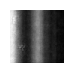

Time for epoch 300 is 78.684490442276 sec
INFO:tensorflow:Assets written to: \Users\aalmans8\Documents\Spic_Optimal_Sigma_VAE\enc_VAE_my_model_299\assets
INFO:tensorflow:Assets written to: \Users\aalmans8\Documents\Spic_Optimal_Sigma_VAE\dec_VAE_my_model_299\assets


In [41]:
tf.config.run_functions_eagerly(True)
train(normalized_ds, 300)

In [42]:
#test(t_normalized_ds, 500)

In [43]:
mean, log_var = enc(iter(normalized_ds).next(), training=False)
latent = final([mean, log_var])
generated_images = dec(latent, training=False)
#sum(sum(sum((generated_images - iter(normalized_ds).next())**2)))
enc.weights[0][1][1]
#loss = vae_loss(images, generated_images, mean, log_var)
#plt.imshow(getNormed(np.array(generated_images))[0, :, :, 0])
#plt.gray()
#plt.show()

<tf.Tensor: shape=(1, 32), dtype=float32, numpy=
array([[-0.05090982,  0.10398904,  0.08210614, -0.09956823,  0.03033668,
        -0.04442488, -0.0780133 , -0.01607547, -0.0609476 , -0.06312167,
         0.01528388,  0.0200591 ,  0.02951515, -0.02185507,  0.11453711,
         0.04312564,  0.06681653, -0.14069076,  0.04028537, -0.10568304,
        -0.04532218, -0.04684397,  0.11196326,  0.14898887,  0.07553938,
         0.03913682,  0.08478604, -0.05999333,  0.07136074,  0.06900285,
         0.06320805, -0.02856592]], dtype=float32)>

In [44]:
np.savetxt(r'\Users\aalmans8\Documents\Spic_Optimal_Sigma_VAE\Results\training_weights\loss_.csv', loss_, fmt="%s",delimiter=",",header="loss")
#np.savetxt(r'\Users\aalmans8\Documents\Spic_Optimal_Sigma_VAE\Results\training_weights\t_loss_.csv', t_loss_, fmt="%s",delimiter=",",header="loss")

In [45]:
loss_ = pd.read_csv(r'\Users\aalmans8\Documents\Spic_Optimal_Sigma_VAE\Results\training_weights\loss_.csv')
#t_loss_ = pd.read_csv(r'\Users\aalmans8\Documents\Spic_Optimal_Sigma_VAE\Results\training_weights\t_loss_.csv')

In [46]:
loss_ = loss_["# loss"].tolist()
#t_loss_ = t_loss_["# loss"].tolist()

In [47]:
len(sigma_lst)

319500

In [48]:
float(sigma_lst[0])

-0.02089945413172245

In [49]:
# Visualize loss history
img_num = 582 # Spic # 345 # Mal -- 
epoch_loss = []
i = 0
for _ in range(300):
    acc_loss = 0.
    for batch in range(img_num):
        # do the training 
        acc_loss += loss_[i]
        i+=1
    epoch_loss.append((float(acc_loss) / img_num))

In [50]:
# Visualize test loss history
'''t_img_num = 145 # Spic 86 # Mal -- 
t_epoch_loss = []
i = 0
for _ in range(300):
    acc_loss = 0.
    for batch in range(t_img_num):
        # do the training 
        acc_loss += t_loss_[i]
        #print(acc_loss)
        i+=1
    t_epoch_loss.append((float(acc_loss) / t_img_num))''' 

't_img_num = 145 # Spic 86 # Mal -- \nt_epoch_loss = []\ni = 0\nfor _ in range(300):\n    acc_loss = 0.\n    for batch in range(t_img_num):\n        # do the training \n        acc_loss += t_loss_[i]\n        #print(acc_loss)\n        i+=1\n    t_epoch_loss.append((float(acc_loss) / t_img_num))'

In [51]:
epoch_count = range(1,len(epoch_loss)+1)
#t_epoch_count = range(1,len(t_epoch_loss)+1)

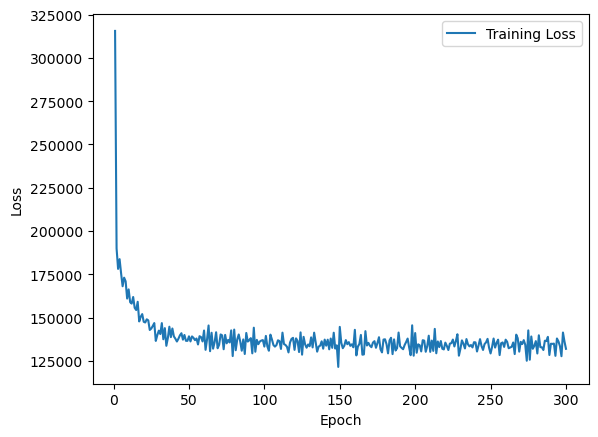

In [52]:
# Visualize loss history
plt.plot(epoch_count, epoch_loss)
#plt.plot(epoch_count, t_epoch_loss)
plt.legend(['Training Loss', 'Testing Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

In [53]:
'''
img_num = 582
i = 0
t_epoch_loss = []
for _ in range(300):
    acc_loss = 0.
    for batch in range(img_num):
        # do the training 
        acc_loss += sigma_lst[i]
        #print(acc_loss)
        i+=1
    t_epoch_loss.append((float(acc_loss) / img_num))
''' 

'\nimg_num = 582\ni = 0\nt_epoch_loss = []\nfor _ in range(300):\n    acc_loss = 0.\n    for batch in range(img_num):\n        # do the training \n        acc_loss += sigma_lst[i]\n        #print(acc_loss)\n        i+=1\n    t_epoch_loss.append((float(acc_loss) / img_num))\n'

In [54]:
#Visualize one image 
list_data = list(normalized_ds)
list_data_copy = list_data 

print(len(list_data_copy))

mean, log_var = enc(list_data_copy[12], training=False)
latent = final([mean, log_var])
generated_images = dec(latent, training=False)
plt.imshow(np.array(list_data_copy[12][0, :,:,0])*127.5+(-1))
plt.gray()
plt.axis(False)
plt.show()

1065


InvalidArgumentError: Index out of range using input dim 3; input has only 3 dims [Op:StridedSlice] name: strided_slice/

In [ ]:
reconst = dec.predict(latent)
#arr = np.array(generated_images)
plt.imshow(np.array(reconst[0, :,:,0])*127.5+(-1))
plt.gray()
plt.axis(False)
plt.show()

In [ ]:
np.array(generated_images[0, :,:,0]*127.5+(-1))

In [ ]:
enc = encoder(input_encoder)
enc.output

In [ ]:
enc.load_weights(r'\Users\aalmans8\Documents\Spic_Optimal_Sigma_VAE\Results\training_weights\enc_299.h5')
dec.load_weights(r'\Users\aalmans8\Documents\Spic_Optimal_Sigma_VAE\Results\training_weights\dec_299.h5')

In [ ]:
# example of calculating the frechet inception distance in Keras
import numpy
from numpy import cov
from numpy import trace
from numpy import iscomplexobj
from numpy import asarray
from numpy.random import randint
from scipy.linalg import sqrtm
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.datasets.mnist import load_data
from skimage.transform import resize
# scale an array of images to a new size
def scale_images(images, new_shape):
    images_list = list()
    for image in images:
        # resize with nearest neighbor interpolation
        new_image = resize(image, new_shape, 0)
        # store
        images_list.append(new_image)
    return asarray(images_list)
# calculate frechet inception distance
def calculate_fid():
    # prepare the inception v3 model
    model = InceptionV3(include_top=False, pooling='avg', input_shape=(299,299,3))
	# calculate activations
    train = x_train/127.5+(-1)
    m, v = enc.predict(train)
    latent = final([m,v])
    reconst = dec.predict(latent)
    
    # resize images
    train = scale_images(train, (299,299,3))
    reconst = scale_images(reconst, (299,299,3))
    print('Scaled', train.shape, reconst.shape)
    
    # pre-process images
    train = preprocess_input(train)
    reconst = preprocess_input(reconst)
    
    act1 = model.predict(train) 
    act2 = model.predict(reconst) 
    
    # calculate mean and covariance statistics
    mu1, sigma1 = act1.mean(axis=0), cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), cov(act2, rowvar=False)
    # calculate sum squared difference between means
    ssdiff = numpy.sum((mu1 - mu2)**2.0)
    # calculate sqrt of product between cov
    covmean = sqrtm(sigma1.dot(sigma2))
    # check and correct imaginary numbers from sqrt
    if iscomplexobj(covmean):
        covmean = covmean.real
    # calculate score
    fid = ssdiff + trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

In [ ]:
# calculate fid
fid = calculate_fid()
print('FID: %.3f' % fid)

# Original training images:

In [ ]:
m, v = enc.predict(x_train[:10]/127.5+(-1)) #dividing by 255 is important to be able to see the images
latent = final([m,v])
reconst = dec.predict(latent)

n = 10  ## how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    ## display original
    ax = plt.subplot(2, n, i+ 1)
    #ax.set_title("Original Image")
    plt.imshow(x_train[i, :,:,0]*127.5+(-1))
    plt.gray()
    plt.axis(False)

    ## display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    #ax.set_title("Reconstructed Image")
    plt.imshow(np.array(reconst[i, :,:,0])*127.5+(-1))
    plt.gray()
    plt.axis(False)

# Testing data:

In [ ]:
figsize = 15
m,v = enc.predict(x_test[:10]/127.5+(-1))
latent = final([m,v])
reconst_test = dec.predict(latent)

n = 10  ## how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    ## display original
    ax = plt.subplot(2, n, i+ 1)
    #ax.set_title("Original Image")
    plt.imshow(x_test[i, :,:,0]*127.5+(-1))
    plt.gray()
    plt.axis(False)

    ## display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    #ax.set_title("Reconstructed Image")
    plt.imshow(np.array(reconst_test[i, :,:,0])*127.5+(-1))
    plt.gray()
    plt.axis(False)

In [ ]:
unique, counts = np.unique(reconst[7,:,:,0]*127.5+(-1), return_counts=True)
print(unique)

In [ ]:
figsize = 15
m,v = enc.predict(x_test[:10]/127.5+(-1))
latent = final([m,v])
#print(v)
#print(m)

In [ ]:
x = np.random.normal(size = (25,70))
reconstruct = dec.predict(x)
fig = plt.figure(figsize=(figsize, 10))

for i in range(25):
    ax = fig.add_subplot(5, 5, i+1)
    ax.axis('off')
    ax.imshow(np.array(reconstruct[i, :,:,0])*127.5+(-1), cmap = 'gray')